In [64]:
using Plots
using LaTeXStrings
using LinearAlgebra
using FFTW
using BenchmarkTools
using Distributions
using Unwrap
using JuMP
using Ipopt
using Unwrap
using Pkg
using Random
# Pkg.add("PyCall") 

In [2]:
function fftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(fft(fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(ifft(ifftshift(B)))
end

ifftnshift (generic function with 1 method)

In [3]:
function fft_1dcustom!(x_re, x_im)
    N = length(x_re)
    @assert N == length(x_im) "re/im must match length"
    @assert ispow2(N) "Length must be a power of two"

    # Bit‑reversal on both real & imag
    bits = Int(floor(log2(N)))
    for i in 0:N-1
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            x_re[i+1], x_re[j+1] = x_re[j+1], x_re[i+1]
            x_im[i+1], x_im[j+1] = x_im[j+1], x_im[i+1]
        end
    end

    # Cooley‑Tuk stages
    m = 1
    while m < N
        half = m
        m *= 2
        θ = -2π / m
        @inbounds for j in 0:half-1
            c = cos(θ*j)     # real constant :contentReference[oaicite:8]{index=8}
            s = sin(θ*j)
            for k in j:m:N-1
                u = k + 1
                v = k + half + 1
                u_re, u_im = x_re[u], x_im[u]
                v_re, v_im = x_re[v], x_im[v]

                # complex multiply (v * cis(θ*j)) in real form
                t_re =  c*v_re - s*v_im
                t_im =  s*v_re + c*v_im

                # butterfly
                x_re[u] = u_re + t_re
                x_im[u] = u_im + t_im
                x_re[v] = u_re - t_re
                x_im[v] = u_im - t_im
            end
        end
    end

    return nothing
end
function fft_2dcustom(A)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = fft_1dcustom!(view(B, :, x, 1), view(B, :, x, 2))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = fft_1dcustom!(view(B, y, :, 1), view(B, y, :, 2))
    end

    return B
end

fft_2dcustom (generic function with 1 method)

In [4]:
function Find_Crossing(func, y_point, x)
    N = length(func)
    f = func .- y_point
    x_intercepts = []

    for i in 1:N-1
        if f[i]*f[i+1] < 0
            # Linear interpolation to find the crossing point
            dfdx = (f[i+1] - f[i]) / (x[i+1] - x[i])
            x_intercept = x[i] - f[i]/dfdx
            x_intercepts = push!(x_intercepts, x_intercept)
        end
        
    end
    return x_intercepts
end
function Find_Spacing(x_intercepts)
    if length(x_intercepts) == 0
        return Inf
    end


    if mod(length(x_intercepts),2) == 1
        x_intercepts = x_intercepts[1:end-1]
    end
    centers = @. (x_intercepts[1:2:end] + x_intercepts[2:2:end])/2
    
    spacing = centers[2:end] .- centers[1:end-1]
    spacing = sort!(spacing)
    return spacing[length(spacing)÷2]
end

Find_Spacing (generic function with 1 method)

In [100]:
function Noisy_Image(A::AbstractMatrix{<:Number}, N_electrons::Real ,
    background_noise::Real, kspace=false) 


    image = copy(A)
    if kspace
    # image is assumed to be in reciprocal space and normally ordered
    image = ifftnshift(image)
    end
    image = abs.(image) # image is assumed to be in real-space and real


    image_normalized = N_electrons .* image./sum(image)
    background_noise = rand(Poisson(background_noise), size(image))
    image_poisson =  rand.(Poisson.(image_normalized))
    image_noisy = image_poisson .+ background_noise

    if kspace
    image_noisy = fftnshift(image_noisy)
    return image_noisy
    end

    return image_noisy
end

function Diff_Image(image, c=0.01)
    return @. log1p(c*abs(image))
end
function Autocorrelation(image)
    # the image is assumed to be in real space
    
    image_fft = fftnshift(image)
    image_auto = ifftnshift(image_fft .* conj.(image_fft))
    if eltype(image) <: Real 
        return real.(image_auto)
    end
    return image_auto
end
function Autocorrelation_Normalized(image)
    # the image is assumed to be in real space
    Ny, Nx = size(image)
    image_auto = Autocorrelation(image)
    image_auto = image_auto./(Ny*Nx)
    image_auto = image_auto .- sum(image_auto)/(Ny*Nx)
    image_auto = image_auto ./ maximum(abs.(image_auto))
    return image_auto
end

Autocorrelation_Normalized (generic function with 1 method)

In [239]:
function Wavelength(E)
    hc = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀ = 511.0 #keV
    return hc/sqrt(abs(E*(2*E₀ + E)))
end

function Focus(E, Cs, nᵢ=1)
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((Cs*Wavelength(E)^3)))^(1/4)

kmax (generic function with 1 method)

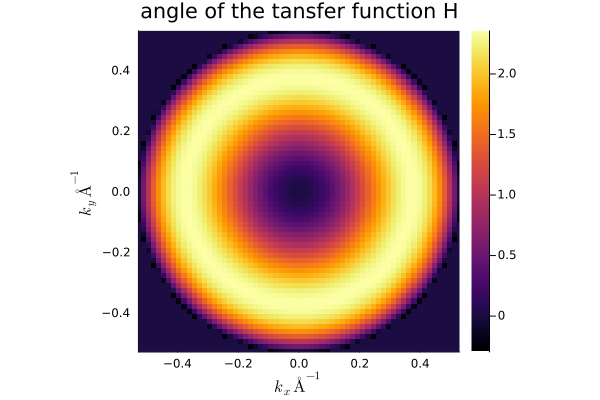

In [233]:
E = 300.0 #keV
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms

N = 2^6
physical_scale = 1
camera_scale = 2

upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = lower:1:upper
ky = lower:1:upper

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2
disk = Float64.(disk)

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)


Δk = kx[2] - kx[1]
L = 1/Δk
ΔL = L/N

x = LinRange(-L/2, L/2, N)
y = LinRange(-L/2, L/2, N)

λ(E) = Wavelength(E)
Δf(E, Cs) = Focus(E, Cs)
χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
H = @. exp(-1im*χ(k)*disk)*disk
f(x, y, xc, yc, σ₁, σ₂) = @. (1/((2*pi)*sqrt(σ₁*σ₂)))*exp(-(x - xc)^2/(2σ₁^2) -(y - yc)^2/(2σ₂^2) )
heatmap(kx, ky, angle.(H), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])

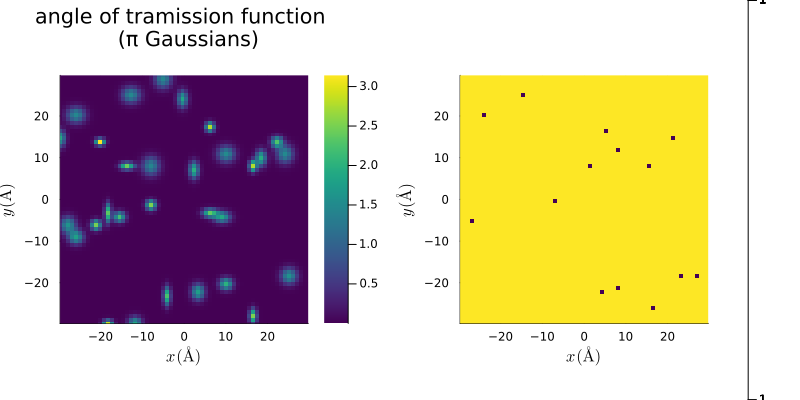

GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY


In [198]:
S = 5
σ₊, σ₋ = 7, 7
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
# indices = round.(Int, LinRange(1, N, S))

# for i in indices, j in indices
#     xc = x[i]
#     yc = y[j]
#     phase_real += f(x',y, xc, yc, σ₊, σ₋)
#     phase_complex += f(x',y, xc, yc, σ₊, σ₋) 
# end
xc, yc = 0.0, 0.0
σx, σy = 1, 7
θ_rot = deg2rad(0)
rotatedx = @. cos(θ_rot)*x' + sin(θ_rot)*y
rotatedy = @. -sin(θ_rot)*x' + cos(θ_rot)*y
Random.seed!(1)
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
for i in 1:30
    xc = rand(x)
    yc = rand(y)
    σx, σy = rand(Uniform(0.5, 1.5)), rand(Uniform(0.5, 1.5))
    phase_real += f(rotatedx,rotatedy, xc, yc, σx, σy)
    phase_complex += f(rotatedx,rotatedy, xc, yc, σx, σy) 
end
# phase_real = f(rotatedx,rotatedy, xc, yc, σx, σy) + f(rotatedx,rotatedy, xc+3, yc, σx, σy)
# phase_complex = f(rotatedx,rotatedy, xc, yc, σx, σy) + f(rotatedx,rotatedy, xc+3, yc, σx, σy)


phase_real = phase_real./maximum(phase_real) *π
phase_complex = phase_complex./maximum(phase_complex) * 0.1
phase = phase_real #+ 1im*phase_complex

transmission = @. cis(phase);


fig1 = heatmap(x,y,abs.(phase), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)
title!("angle of tramission function \n (π Gaussians)")
# vline!([spacing_x], color=:black, lw=2)
# hline!([spacing_y], color=:black, lw=2)

fig2 = heatmap(x,y,abs.(transmission), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)

plot(fig1, fig2, layout=(1,2), size=(800, 400), legend=false)

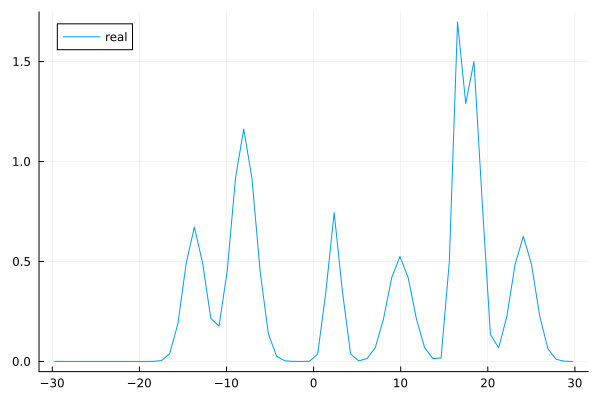

In [199]:
plot(x,phase_real[N÷2+10,:], label="real")

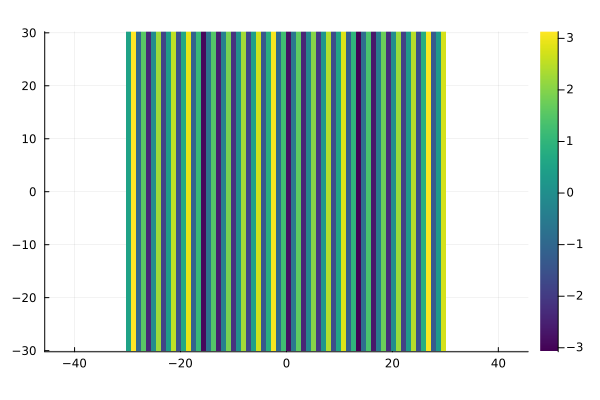

In [200]:
Reference_Wave(θ, ϕ) = @. exp(1im * 2*π/kmax(E,Cs) * (sin(θ)*cos(ϕ)*x' + sin(θ)*sin(ϕ)*y))
wave_ref = ifftnshift(fftnshift(Reference_Wave(0.2, 0)).*H)
transmission = @. exp(1im * phase);
heatmap(x, y, angle.(wave_ref), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)


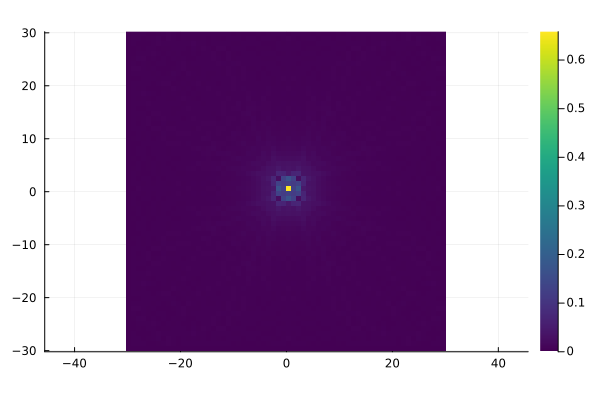

In [201]:
probe = ifftnshift(H)
probe = probe./sqrt(sum(abs2.(probe)))
heatmap(x, y, abs.(probe), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

In [202]:
raster_shifts = @. cispi(2*(kx' * x' + ky * y))

heatmap(x, y, angle.(raster_shifts), 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=true, 
    xlabel="x", 
    ylabel="y");

In [203]:
function Rasters_fft(raster_shifts, tf_wave_fft, H)
    Ny, Nx = size(raster_shifts)
    # rasters_fft = Array{ComplexF64}(undef, N, N, N, N)
    common_factor = @. tf_wave_fft * H  # element-wise multiplication of tf_wave_fft and H
    rasters_fft = reshape(raster_shifts, Ny, Nx, 1, 1) .* reshape(common_factor, 1, 1, Ny, Nx)
    return rasters_fft
end

Rasters_fft (generic function with 1 method)

In [204]:
wave_obj_fft = fftnshift(transmission.*probe)
rasters_fft = Rasters_fft(raster_shifts, wave_obj_fft, H);

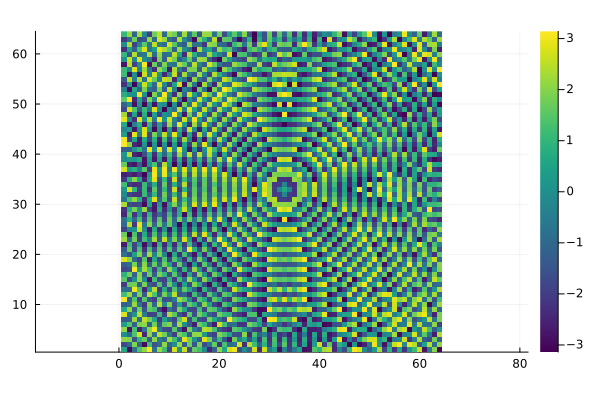

In [205]:
heatmap(angle.(ifftnshift(rasters_fft[1, 1, :, :])), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

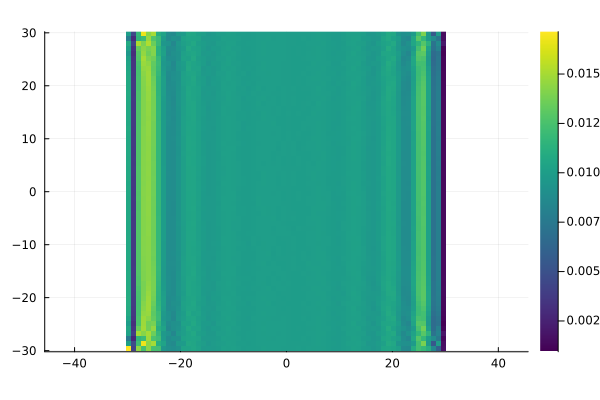

In [206]:

measurement(i,j) = abs2.(wave_ref .+ ifft(rasters_fft[i,j,:,:]))
measurement_noisy(i,j,N_electrons=1e1,B=0.1) = Noisy_Image(measurement(i,j), N_electrons, B)


measurement_fft(i,j) = @. fftnshift(measurement_noisy(i,j))
measurement_autocorr(i,j) = Autocorrelation_Normalized(measurement(i,j))
heatmap(x, y, Diff_Image(measurement(1,1)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true) 
# heatmap(x, y, Diff_Image(measurement_fft(1,1)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true) 
# heatmap(kx, ky, Diff_Image(measurement_fft(30,30)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true); 

In [207]:
measurement_noised = Array{Float64}(undef, N, N, N, N)
for i in 1:N, j in 1:N
    measurement_noised[i,j,:,:] = Noisy_Image(measurement(i,j), 1e1, 0.1)
end
noised_reshaped = reshape(measurement_noised, N*N*N*N);

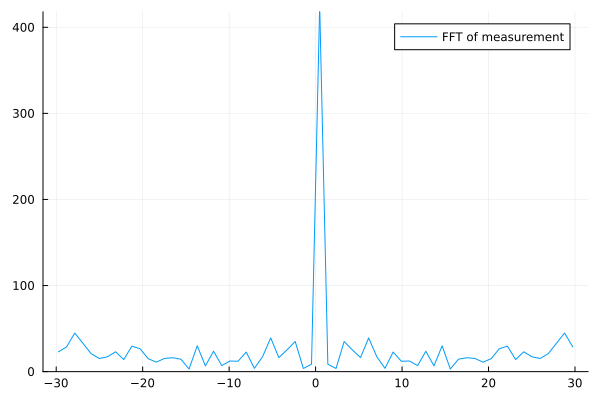

In [208]:
shift = -1
k, l = 15, 3
plot(x,abs.(measurement_fft(k,l)[N÷2-shift,:]), label="FFT of measurement", legend=:topright)
ylims!(0,maximum(abs.(measurement_fft(k,l)))*1)

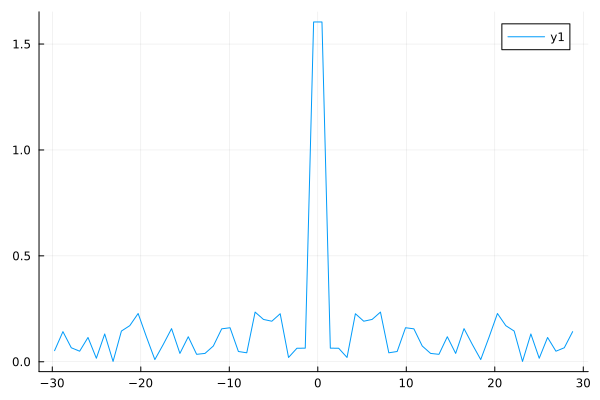

In [209]:
plot(x[1:end-1],Diff_Image(diff(abs.(measurement_fft(k,l)[N÷2-shift,:]))))

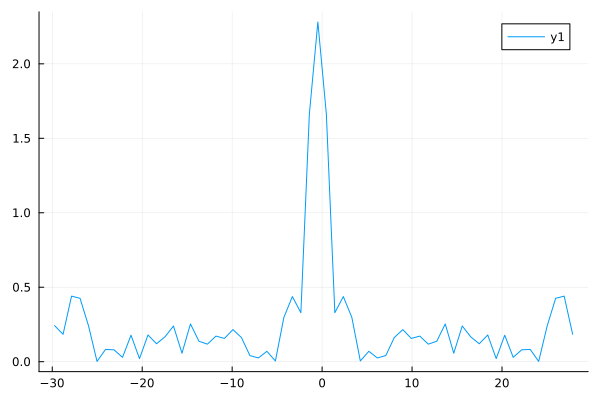

In [210]:
plot(x[1:end-2],Diff_Image(diff(diff(abs.(measurement_fft(k,l)[N÷2-shift,:])))))

In [211]:
# using Optimization, OptimizationBBO
using AdaptiveMCMC


# const rf_wave = reference_term(θ,ϕ)
#  2π/Wavelength(E) * sin(θ)*(cos(ϕ)*x' + sin(ϕ)*y)
Ty, Tx = N, N
x_len = Ty*Tx
wave_reference = @. kmag * (sin(θ)*cos(ϕ)*x' + sin(θ)*sin(ϕ)*y)
# using Optimization, OptimizationBBO
using AdaptiveMCMC


# const rf_wave = reference_term(θ,ϕ)
#  2π/Wavelength(E) * sin(θ)*(cos(ϕ)*x' + sin(ϕ)*y)
Ty, Tx = 64, 64
x_len = Ty*Tx
wave_reference = @. kmag * (sin(θ)*cos(ϕ)*x' + sin(θ)*sin(ϕ)*y)

# # wave_reference = reshape(wave_reference, N,N,1)
const wave_ref_flat = vec(wave_reference[1:Ty, 1:Tx])
const ideal_flat = vec(ideal_measured[1:Ty, 1:Tx])
# measured_flat = vec(ideal_measured[1:Ty, 1:Tx])

A = Array{Float64}(undef, 2*Ty*Tx)
param = 5
function ll_termbb(x::AbstractVector{Float64}, param=param)
    # Reshape x into a 3D array of size (Ny, Nx, 2)
    # x_mat = reshape(x[:], Ty, Tx, 2)

    
    A = @views @. exp(-2 * x[end]*x[1:Ty*Tx]) + 1 + 2 * exp(-x[end]*x[1:Ty*Tx]) * cos(x[end-1]*x[1:Ty*Tx] + wave_ref_flat)
    # A = @. exp(-2 * x_mat[:,:,1]) + 1 + 2 * exp(-x_mat[:,:,1]) * cos(x_mat[:,:,2] + wave_reference[1:Ty,1:Tx])
    x_shaped = reshape(x[1:end-2], Ty, Tx)
    phi_grady = diff(x_shaped, dims=1)
    phi_gradx = diff(x_shaped, dims=2)
    return -sum((A.-ideal_flat).^2) - param.*(sum(phi_grady.^2) + sum(phi_gradx.^2))
    # return -sum(j.^2)
end
test_A(x) = @views @. exp(-2 * x[end]*x[1:Ty*Tx]) + 1 + 2 * exp(-x[end]*x[1:Ty*Tx]) * cos(x[end-1]*x[1:Ty*Tx] + wave_ref_flat[1:Ty*Tx])

# log_p(x) = -sum(x.^2)
# using Random, Distributions
# Ty, Tx = 64
rand_func(rng, x) = 0.5.*randn!(rng, x)
n = 200_000
rwm = adaptive_rwm(zeros(x_len + 2),
         ll_termbb, n; thin=10, L=3,
         algorithm=:asm, q=rand_func)
# # wave_reference = reshape(wave_reference, N,N,1)
const wave_ref_flat = vec(wave_reference[1:Ty, 1:Tx])
const ideal_flat = vec(ideal_measured[1:Ty, 1:Tx])
# measured_flat = vec(ideal_measured[1:Ty, 1:Tx])

A = Array{Float64}(undef, 2*Ty*Tx)
param = 5
function ll_termbb(x::AbstractVector{Float64}, param=param)
    # Reshape x into a 3D array of size (Ny, Nx, 2)
    # x_mat = reshape(x[:], Ty, Tx, 2)

    
    A = @views @. exp(-2 * x[end]*x[1:Ty*Tx]) + 1 + 2 * exp(-x[end]*x[1:Ty*Tx]) * cos(x[end-1]*x[1:Ty*Tx] + wave_ref_flat)
    # A = @. exp(-2 * x_mat[:,:,1]) + 1 + 2 * exp(-x_mat[:,:,1]) * cos(x_mat[:,:,2] + wave_reference[1:Ty,1:Tx])
    x_shaped = reshape(x[1:end-2], Ty, Tx)
    phi_grady = diff(x_shaped, dims=1)
    phi_gradx = diff(x_shaped, dims=2)
    return -sum((A.-ideal_flat).^2) - param.*(sum(phi_grady.^2) + sum(phi_gradx.^2))
    # return -sum(j.^2)
end
test_A(x) = @views @. exp(-2 * x[end]*x[1:Ty*Tx]) + 1 + 2 * exp(-x[end]*x[1:Ty*Tx]) * cos(x[end-1]*x[1:Ty*Tx] + wave_ref_flat[1:Ty*Tx])

# log_p(x) = -sum(x.^2)
# using Random, Distributions
# Ty, Tx = 64
rand_func(rng, x) = 0.5.*randn!(rng, x)
n = 200_000
rwm = adaptive_rwm(zeros(x_len + 2),
         ll_termbb, n; thin=10, L=3,
         algorithm=:asm, q=rand_func)

UndefVarError: UndefVarError: `kmag` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [237]:
println(Wavelength(E))

0.019686806700005176


In [ ]:
function H_transfer(Cs,k_grid=k,Energy::T=E, bin_disk=disk) where {T<:AbstractFloat}
    # returns the transfer function H matrix
    χ = @. π*Wavelength(Energy)*k_grid^2*(0.5*Cs*Wavelength(Energy)^2*k_grid^2 - sqrt(3/2 * Cs * Wavelength(Energy)))
    
    return @. cis(-χ*bin_disk)*bin_disk
end
function H_transfer(Cs,θ,φ,Energy::T=E) where {T<:AbstractFloat}
    # returns the transfer function H scalar
    kxy_mag2 = (sin(θ)/Wavelength(Energy))^2  
    χ = π*Wavelength(Energy)*kxy_mag2*(0.5*Cs*Wavelength(Energy)^2*kxy_mag2 - sqrt(3/2 * Cs * Wavelength(Energy)))
    
    if kxy_mag2 > kmax(E,Cs)^2
        return 0.0
    end
    return cis(-χ)
end




function wiggle_factor_2ndterm(θ::T,φ::T, x::AbstractVector{T}=x, y::AbstractVector{T}=y,
                     Energy::T=E) where {T<:AbstractFloat} 
    return @. cispi(2*sin(θ)/Wavelength(Energy) * (cos(φ)*x' + sin(φ)*y))
end


function first_term(Cs::T,ϕ::AbstractMatrix{T} , k_grid=k, 
    wiggle_factor::AbstractMatrix{Complex{T}} = raster_shifts) where {T<:AbstractFloat}

    return cis(ϕ).*ifftnshift(wiggle_factor.*H_transfer(Cs))
end
function second_term(Cs::T, θ::T, φ::T) where {T<:AbstractFloat}
    return H_transfer(Cs, θ, φ).*wiggle_factor_2ndterm(θ, φ)
end

second_term (generic function with 1 method)

In [213]:
using Random
using Turing
using MCMCChains
using AdvancedHMC
using StatsPlots
using Distributions
using Pkg
Pkg.add("AdvancedMH")
using AdvancedMH

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
Precompiling project...
           ✗ BlackBoxOptim → BlackBoxOptimRealtimePlotServerExt
  0 dependencies successfully precompiled in 2 seconds. 805 already precompiled.


In [259]:
Threads.nthreads()

8

In [ ]:
Random.seed!(1)  # For reproducibility
@model function infinite_chain(y, Nx=N, Ny=N)
    # Priors
    # Cs = 1 #mm
    # Cs = Cs * 1e7 #convert to Angstroms
    B ~ Exponential(1)
    Cs ~ truncated(Normal(1e7, 3e6), 0, Inf)
    θ ~ Exponential(20)
    φ ~ Normal(0, 0.1)
    ϕ ~ filldist(truncated(Normal(π/2, π),0,3*π/2), Ny, Nx)


    # Likelihood
    
    y ~ arraydist(Poisson.(vec(
        abs2.(
            reshape(first_term(Cs, ϕ),Ny,Nx,1,1 ) .+ 
            reshape(second_term(Cs, θ, φ), 1, 1, Ny, Nx)) 
            .+ B)))
    
end
# Generate synthetic data
n = 1_000

# Fit the model
model = infinite_chain(noised_reshaped)
sampler = Turing.MH()
chain = sample(model, sampler, MCMCThreads(), n, 8, progress=true)
# Plot the results
# plot(x,y)

Sampling (8 threads)   0%|                              |  ETA: N/A


In [270]:
size(chain)

(100, 4101, 8)

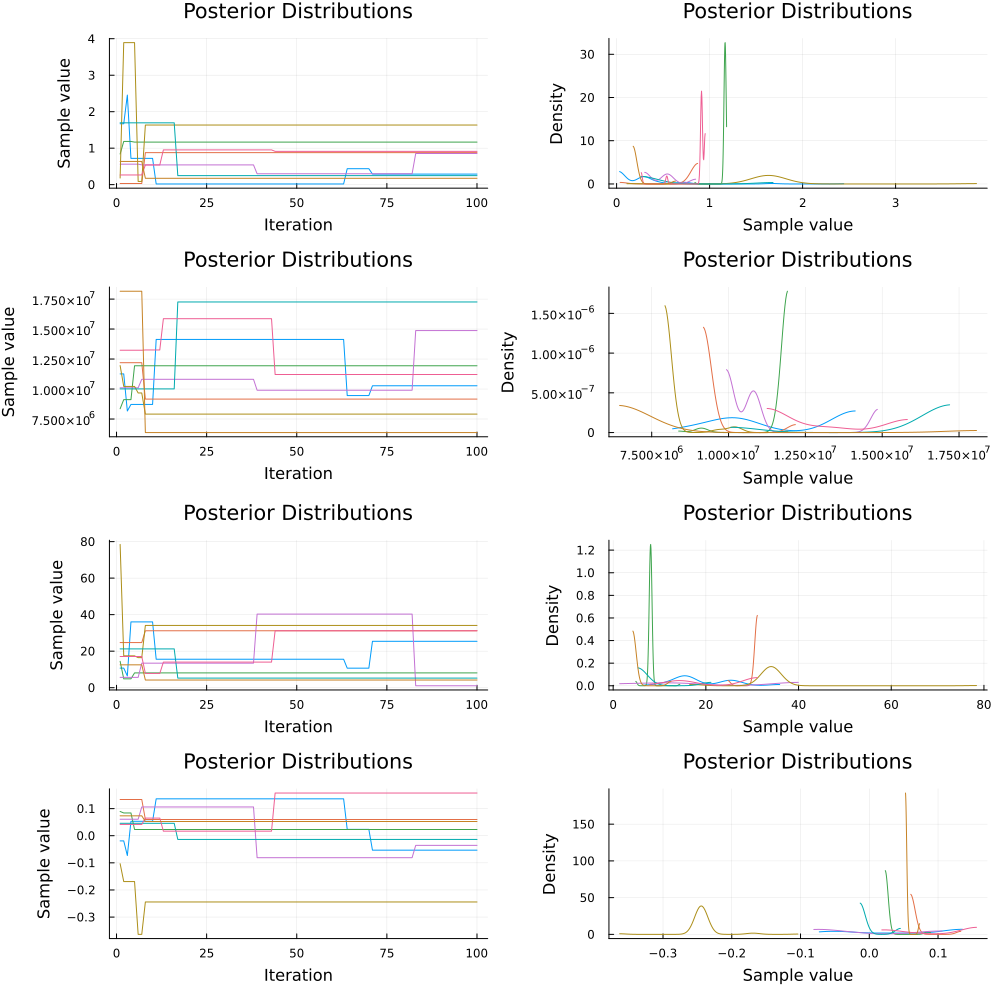

In [271]:
plot(chain[:,1:4,:], labels=["B", "Cs", "θ", "φ"], title="Posterior Distributions", xlabel="Parameter Value", ylabel="Density")

In [264]:
summaries, quantiles = describe(chain)

2-element Vector{ChainDataFrame}:
 Summary Statistics (4100 x 8)
 Quantiles (4100 x 6)

In [265]:
summaries

Summary Statistics
  parameters           mean            std          mcse   ess_bulk   ess_tail ⋯
      Symbol        Float64        Float64       Float64    Float64    Float64 ⋯

           B         0.9981         0.7809        0.2973     8.0165        NaN ⋯
          Cs   9514745.5465   1051120.3272   305475.6024    10.1673        NaN ⋯
           θ        11.3622        12.4415        4.5153     7.3269        NaN ⋯
           φ         0.0818         0.0962        0.0337     8.0166        NaN ⋯
     ϕ[1, 1]         1.6775         1.1855        0.4078     9.1330        NaN ⋯
     ϕ[2, 1]         3.0878         1.2114        0.4553     7.0066        NaN ⋯
     ϕ[3, 1]         1.3447         0.9193        0.2643    11.3407        NaN ⋯
     ϕ[4, 1]         3.0756         0.5803        0.2171     7.4518        NaN ⋯
     ϕ[5, 1]         2.5624         1.2103        0.4089    11.3407        NaN ⋯
     ϕ[6, 1]         1.8730         1.1573        0.4254     7.3229        NaN ⋯
     ϕ[7

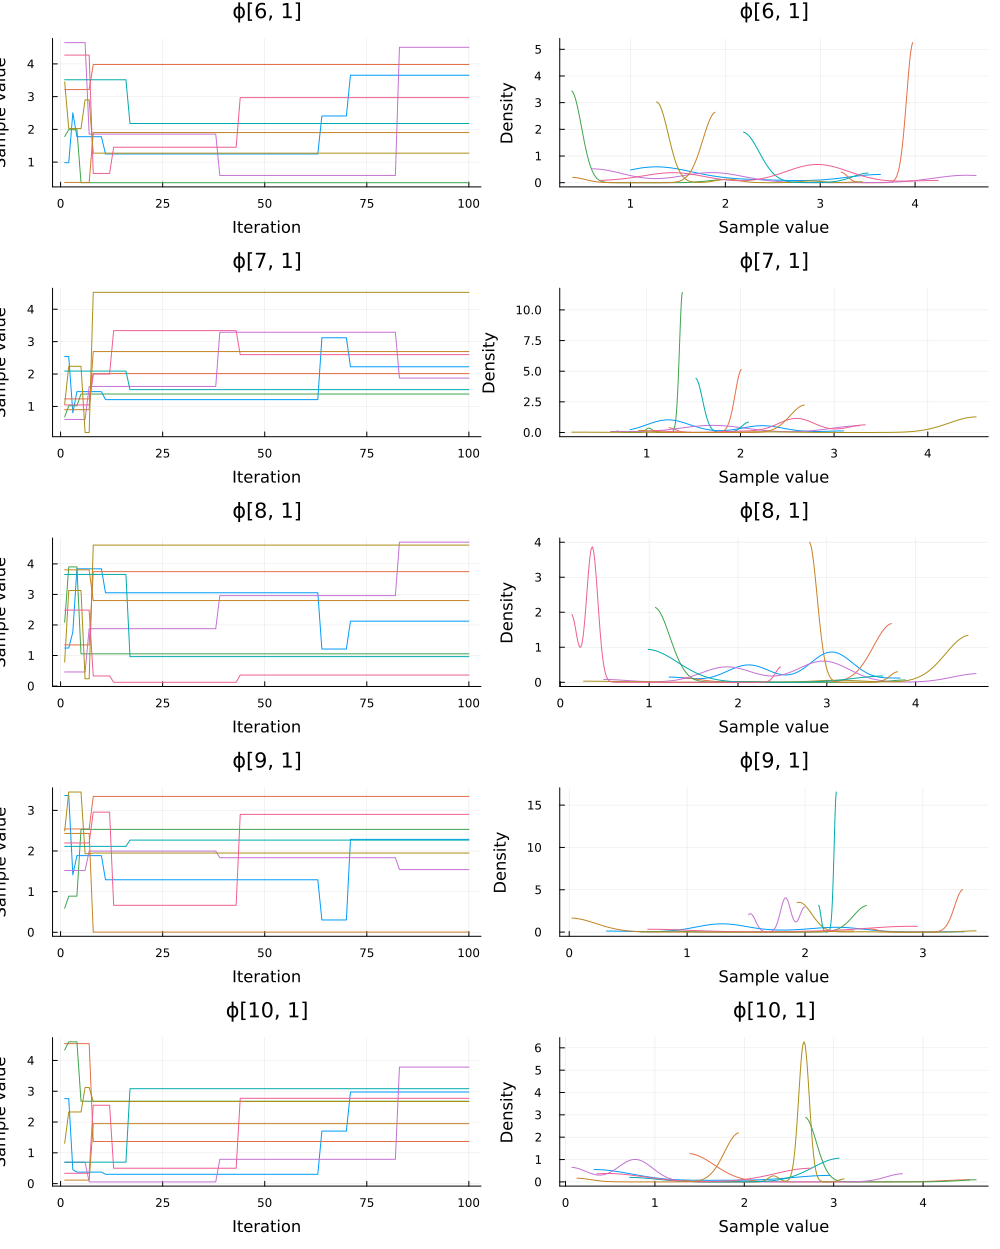

In [272]:
plot(chain[:,10:14,:])

In [267]:
# Suppose you want the first element of φ for each sample:
plot(chain[:, ["B", "Cs", "θ", "φ"], :], seriestype=:trace, title="Trace Plots")# plot(chain, seriestype=:density, title="Density Plots")


AssertionError: AssertionError: all((ptype->begin
            #= /home/nicolas/.julia/packages/MCMCChains/RIFg4/src/plot.jl:207 =#
            ptype ∈ supportedplots
        end), ptypes)